# Exercise 3

### Enric Fita
### Shivali Dubey

In [6]:
import os
os.chdir('C:\WS 2018\Lectures\Optimization_for_Machine_LEarning_Bogdan\Ex3')

In [ ]:
# %load Exercise3.py
#!/usr/bin/env python3

import random
from grid import Grid,determine_grid,row_column_decomposition
import numpy as np
from collections import namedtuple
import copy


#Exercise 3.1

def evaluate_energy(nodes, edges, assignment):

	energy = 0
	for i in range(len(nodes)):
		energy = nodes[i].costs[assignment[i]] + energy
		
	for j in range(len(edges)):
		energy = edges[j].costs[assignment[edges[j].left],assignment[edges[j].right]] + energy
			
		
	return energy

#Random initialisation
def Rand_ini(nodes):
	labeling=[]
	for i in range(len(nodes)):
		labeling.append(random.randint(0,len(nodes[i].costs)-1))
	return labeling


def ICM_update_energy(Grid_,pos_node,Labeling,energy=0,prev_lab=None):
	if prev_lab==None:
		new_energy=Grid_._nodes[pos_node].costs[Labeling[pos_node]]
		for edge in Grid_.edges(pos_node,True):
			if edge.left==pos_node:
				new_energy=new_energy+edge.costs[Labeling[pos_node],Labeling[edge.right]]
			else:
				new_energy=new_energy+edge.costs[Labeling[edge.left],Labeling[pos_node]]
		return new_energy
	
	
	new_energy=energy-Grid_._nodes[pos_node].costs[prev_lab]+Grid_._nodes[pos_node].costs[Labeling[pos_node]]
	
	for edge in Grid_.edges(pos_node,True):
		if edge.left==pos_node:
				new_energy=new_energy-edge.costs[prev_lab,Labeling[edge.right]]+edge.costs[Labeling[pos_node],Labeling[edge.right]]
		else:
			new_energy=new_energy-edge.costs[Labeling[edge.left],prev_lab]+edge.costs[Labeling[edge.left],Labeling[pos_node]]
	return new_energy

#ICM
def ICM(grid):
	#Random initialisation
	labeling=Rand_ini(grid._nodes)
	
	update=True
	nodes_order=[x for x in range(len(grid._nodes))]
	
	while update:
		update=False
		random.shuffle(nodes_order)
		for i in nodes_order:
			min_lab=labeling[i]
			min_energy=ICM_update_energy(grid,i,labeling)
			for lab in range(len(grid._nodes[i].costs)):
				if lab!=min_lab:
					labeling[i]=lab
					energy=ICM_update_energy(Grid_=grid,pos_node=i,Labeling=labeling,energy=min_energy,prev_lab=min_lab)
					if energy<min_energy:
						update=True
						min_lab=lab
						min_energy=energy
			labeling[i]=min_lab
	return labeling
			



def dynamic_programming_tree(nodes,edges):
	F=[]
	
	for i in range(len(nodes)):
		F.append(copy.deepcopy(nodes[i].costs))
	
	#Calculates edges associated with each node. Position i of the list correspond to the edges incident to vertex 
	# i. Length of list of position i gives degree of i
	degree_nodes=[[] for _ in range(len(nodes))]
	for e in range(len(edges)):
		degree_nodes[edges[e].left].append(e)
		degree_nodes[edges[e].right].append(e)
		
	r=[np.zeros(len(nodes[i].costs)) for i in range(len(nodes))]
	order=[] #stores order of visited leaves and neighbour
	while  any(degree_nodes):
		edge_leave,leave,neighbour_leave=find_leave(degree_nodes,edges)
		degree_nodes[leave]=None
		degree_nodes[neighbour_leave].remove(edge_leave)
		
		for s in range(np.size(F[neighbour_leave])):
			F_S=[]
			for t in range(np.size(F[leave])):
				label_edge=(s,t)*(edges[edge_leave].left==neighbour_leave)+(t,s)*(edges[edge_leave].left==leave)
				F_S.append(F[leave][t]+edges[edge_leave].costs[label_edge])
			F[neighbour_leave][s]=F[neighbour_leave][s]+min(F_S)
			r[leave][s]=np.argmin(F_S)
		order.append((leave,neighbour_leave))
	


	intermediates=[F,r,order]
	return(intermediates)

def find_leave(degree_nodes,edges):
	leave=-1
	for i in degree_nodes:
		leave=leave+1
		if i!=None:
			if len(i)==1:
				neighbour_leave=(edges[i[0]].left!=leave)*edges[i[0]].left+(edges[i[0]].right!=leave)*edges[i[0]].right
				edge_leave=i[0]
			
				return edge_leave,leave,neighbour_leave
	return None,None,None
		
def backtrack_tree(nodes,edges,F,r,order):
	assignment=[0]*len(nodes)
	energy_ls=[]
	leave=order[-1][-1]
	for t in range(np.size(F[leave])):
		energy_ls.append(F[leave][t])
	assignment[leave]=np.argmin(energy_ls)
	
	for i in reversed(range(len(order))):
		assignment[order[i][0]]=int(r[order[i][0]][int(assignment[order[i][1]])])

	
	return(assignment)	

Node = namedtuple('Node', 'costs')
Edge = namedtuple('Edge', 'left right costs')

def create_aux_graph(sub_graph,labeling,grid):
	nodes = []
	edges = []
	set_edges_subgraph=set()
	for edge in sub_graph:
		set_edges_subgraph.add((edge.left,edge.right))
	
	for edge in sub_graph:
		cost=grid._nodes[edge.left].costs
		node=edge.left
		neighbours=grid.edges(node,True)
		set_neighbours=set()
		for edge_neigh in neighbours:
			set_neighbours.add((edge_neigh.left,edge_neigh.right))
		edges_node_not_subgraph=list(set_neighbours-set_edges_subgraph)


		costs_new_graph=cost.copy()
		for i in range(len(cost)):
			for edge2 in neighbours:
				if (edge2.left,edge2.right) in edges_node_not_subgraph:
					if edge2.left==node:
						costs_new_graph[i]=costs_new_graph[i]+edge2.costs[i,labeling[edge2.right]] 
					else:
						costs_new_graph[i]=costs_new_graph[i]+edge2.costs[labeling[edge2.left],i] 
		nodes.append(Node(costs=costs_new_graph))

	#For right node of the last edge
	cost=grid._nodes[edge.right].costs
	node=edge.right
	neighbours=grid.edges(node,True) 
	set_neighbours=set()
	for edge_neigh in neighbours:
		set_neighbours.add((edge_neigh.left,edge_neigh.right))
	edges_node_not_subgraph=list(set_neighbours-set_edges_subgraph)
	costs_new_graph=cost.copy()
	for i in range(len(cost)):
		for edge2 in neighbours:
			if (edge2.left,edge2.right) in edges_node_not_subgraph:
				if edge2.left==node:
					costs_new_graph[i]=costs_new_graph[i]+edge2.costs[i,labeling[edge2.right]] 
				else:
					costs_new_graph[i]=costs_new_graph[i]+edge2.costs[labeling[edge2.left],i] 
	nodes.append(Node(costs=costs_new_graph))
	edges=[Edge(left=i, right=i+1, costs=sub_graph[i].costs) for i in range(len(sub_graph))]
	return nodes,edges

def trans_labeling_to_big_graph(sub_graph,aux_labeling,labeling_):
	count=0
	labeling=labeling_.copy()
	for e in sub_graph:
		
		labeling[e.left]=aux_labeling[count]
		
		count=count+1
	labeling[sub_graph[-1].right]=aux_labeling[-1]
	return labeling


def trans_labeling_to_aux_graph(sub_graph,labeling_):
	count=0
	aux_old_labeling=[0]*(len(sub_graph)+1)
	for e in sub_graph:
		aux_old_labeling[count]=labeling_[e.left]
							
		count=count+1
	aux_old_labeling[-1]=labeling_[sub_graph[-1].right]
	return aux_old_labeling
#BLOCK-ICM
def Block_ICM(grid):
	#Random initialisation
	labeling=Rand_ini(grid._nodes)
	decomp=row_column_decomposition(grid)
	update=True
	while update:
		update=False
		random.shuffle(decomp)
		for sub_graph in decomp:
			aux_sub_graph=create_aux_graph(sub_graph,labeling,grid)
			intermediates=dynamic_programming_tree(aux_sub_graph[0],aux_sub_graph[1])
			aux_labeling=backtrack_tree(aux_sub_graph[0],aux_sub_graph[1],*intermediates)
			aux_old_labeling=trans_labeling_to_aux_graph(sub_graph,labeling)
			old_energy_aux=evaluate_energy(aux_sub_graph[0],aux_sub_graph[1],aux_old_labeling)
			new_energy_aux=evaluate_energy(aux_sub_graph[0],aux_sub_graph[1],aux_labeling)
			if new_energy_aux<old_energy_aux:
				new_labeling=trans_labeling_to_big_graph(sub_graph,aux_labeling,labeling)
				update=True
				labeling=new_labeling
	return labeling





#%%
#Exercise 3.4
    

def TRWS(grid,N=10,T_=2):
    F={}
    B={}
    r={}
    num_nodes=len(grid._nodes)
    #first u_num for node
    # following (u_num,v_num ) refer to edge
    for u_num in range(num_nodes):
        for v_num in grid.neighbors(u_num,isotropic=True):
            if u_num<v_num:
                F[(u_num,u_num,v_num)]=[0]*len(grid._nodes[u_num].costs)
                B[(u_num,u_num,v_num)]=[0]*len(grid._nodes[u_num].costs)
                r[(u_num,u_num,v_num)]=[0]*len(grid._nodes[u_num].costs)
            else:
                F[(u_num,v_num,u_num)]=[0]*len(grid._nodes[u_num].costs)
                B[(u_num,v_num,u_num)]=[0]*len(grid._nodes[u_num].costs)
                r[(u_num,v_num,u_num)]=[0]*len(grid._nodes[u_num].costs)
    
    list_nodes=[i for i in range(num_nodes)]
    for t in range(N):
        for u_num in list_nodes:
            u=grid._nodes[u_num]
            u_num_labels=len(u.costs)
            hat_theta=[]
            for s in range(u_num_labels):
                theta_aux=u.costs[s]
                for v_num in grid.neighbors(u_num,isotropic=True):
                    if v_num<u_num:
                        theta_aux=theta_aux+F[(u_num,v_num,u_num)][s]
                    else:
                        theta_aux=theta_aux+B[(u_num,u_num,v_num)][s]
                hat_theta.append(theta_aux)
            
            for edge in grid.edges(u_num):
                v_num=edge.right
                v=grid._nodes[v_num]
                for l in range(len(v.costs)):
                    aux_list=[]
                    for s in range(u_num_labels):
                        aux_list.append(hat_theta[s]/T_-B[(u_num,u_num,v_num)][s]+edge.costs[s,l])
                    F[(v_num,u_num,v_num)][l]=np.min(aux_list)
                    r[(v_num,u_num,v_num)][l]=np.argmin(aux_list)
        
        dict_aux=F.copy()
        F=B.copy()
        B=dict_aux.copy()
        list_nodes=list_nodes[::-1]
    assignment=reconstruct_labeling(grid,B)
    return assignment

def reconstruct_labeling(grid,B):
    num_nodes=len(grid._nodes)
    u_num=num_nodes-1
    u=grid._nodes[u_num]
    assignment=[0]*num_nodes
    aux_list=[]
    for s in range(len(u.costs)):
        aux_sum=0
        for v_num in grid.neighbors(u_num,isotropic=True):
            if u_num<v_num:
                aux_sum=aux_sum-B[(u_num,u_num,v_num)][s]
            else:
                aux_sum=aux_sum-B[(u_num,v_num,u_num)][s]
        aux_list.append(u.costs[s]-aux_sum)
    assignment[u_num]=np.argmin(aux_list)
    
    for u_num in reversed(range(num_nodes-1)):
        u=grid._nodes[u_num]
        aux_list=[]
        for s in range(len(u.costs)):
            aux_sum=0
            for edge in grid.edges(u_num,isotropic=True):
                if u_num==edge.left:
                    v_num=edge.right
                else:
                    v_num=edge.left
                if u_num<v_num:
                    aux_sum=aux_sum+(u_num==edge.left)*edge.costs[s,assignment[v_num]]+(v_num==edge.left)*edge.costs[assignment[v_num],s]
                else:
                    aux_sum=aux_sum+B[(u_num,v_num,u_num)][s]
            aux_list.append(u.costs[s]+aux_sum)
        assignment[u_num]=np.argmin(aux_list)
    return assignment

#from tsukuba_model import all_models
#from tsukuba_visualize import to_image
#import matplotlib.pyplot as plt
#from grid import determine_grid
#import numpy as np
#import time
#models=all_models()
#count=0
#for model in models:
#    print('MODEL DOWN',2**(5-count))
#    
#    grid=determine_grid(model[0],model[1])
#    
#    start= time.time()
#    assignment=TRWS(grid)
#    end= time.time()
#    energy=evaluate_energy(grid._nodes, grid._edges, assignment)
#    img_size=(12*(2**count),9*(2**count))
#    print (img_size)
#    print('Objective cost=',energy)
#    print('Time elapsed', end-start)
#    img=to_image(assignment,img_size)
#    plt.imshow(np.asarray(img),cmap='gray')
#    plt.show()
#    count=count+1

In [1]:
from Exercise3 import ICM,Block_ICM,evaluate_energy
from tsukuba_model import all_models
from tsukuba_visualize import to_image
import matplotlib.pyplot as plt
from grid import determine_grid

import time

### Exercise 3.1

#### ICM
Type: Primal

Guarantees: None, but in each iteration the cost decreases

Complexity per iteration: O(N\*L) where N is the number of nodes and L is the number of labels. In each node it has to check all the labels and take the minimum

MODEL DOWN 32
(12, 9)
Objective cost= 404.0
Time elapsed 8.177757263183594e-05


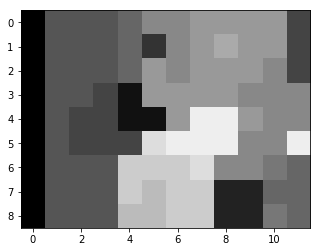

MODEL DOWN 16
(24, 18)
Objective cost= 1370.0
Time elapsed 0.0003859996795654297


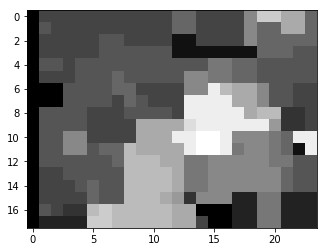

MODEL DOWN 8
(48, 36)
Objective cost= 4770.0
Time elapsed 0.002798795700073242


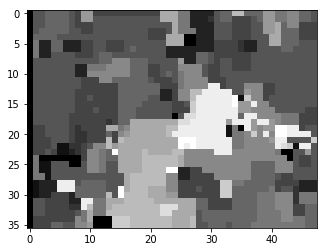

MODEL DOWN 4
(96, 72)
Objective cost= 16714.0
Time elapsed 0.01364898681640625


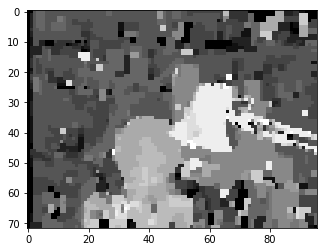

MODEL DOWN 2
(192, 144)
Objective cost= 63098.0
Time elapsed 0.05653882026672363


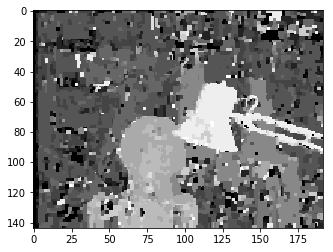

MODEL DOWN 1
(384, 288)
Objective cost= 253475.0
Time elapsed 0.2174053192138672


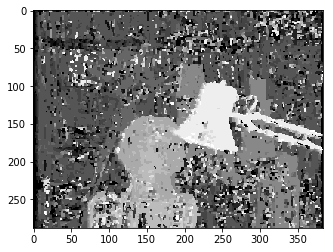

In [2]:

models=all_models()
count=0
for model in models:
    print('MODEL DOWN',2**(5-count))
    
    grid=determine_grid(model[0],model[1])
    assignment=ICM(grid)
    start= time.time()
    energy=evaluate_energy(grid._nodes, grid._edges, assignment)
    end= time.time()
    img_size=(12*(2**count),9*(2**count))
    print (img_size)
    print('Objective cost=',energy)
    print('Time elapsed', end-start)
    img=to_image(assignment,img_size)
    plt.imshow(img)
    plt.show()
    count=count+1


#### BLOCK-ICM

Type: Primal

Guarantees: None, but in each iteration the cost decreases

Complexity per iteration: O(D\*(V\*L²)) where D is the number of subgraphs, V is the number of nodes per subgraph and L the number of labels. We use Dynamic Programming, which has a complexity O(V\*L²) to find the minimimum of a subgraph .

MODEL DOWN 32
(12, 9)
Objective cost= 336.0
Time elapsed 0.00011658668518066406


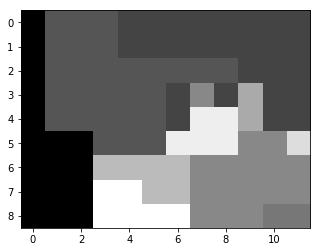

MODEL DOWN 16
(24, 18)
Objective cost= 1067.0
Time elapsed 0.0007572174072265625


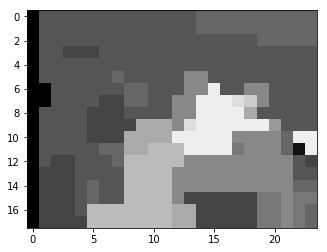

MODEL DOWN 8
(48, 36)
Objective cost= 3525.0
Time elapsed 0.0034170150756835938


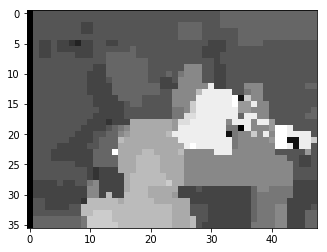

MODEL DOWN 4
(96, 72)
Objective cost= 11160.0
Time elapsed 0.01468515396118164


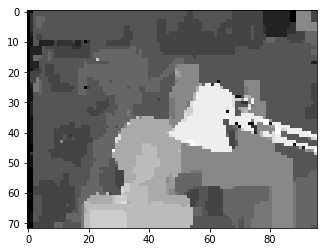

MODEL DOWN 2
(192, 144)
Objective cost= 36497.0
Time elapsed 0.05978536605834961


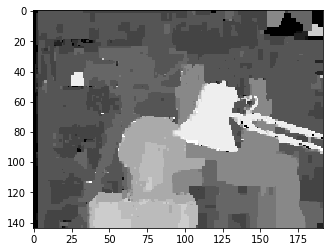

MODEL DOWN 1
(384, 288)
Objective cost= 135502.0
Time elapsed 0.2791168689727783


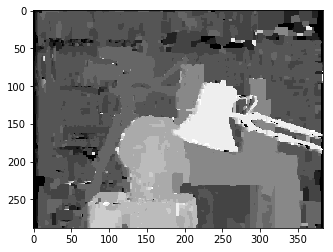

In [3]:

from Exercise3 import ICM,Block_ICM,evaluate_energy
from tsukuba_model import all_models
from tsukuba_visualize import to_image
import matplotlib.pyplot as plt
from grid import determine_grid


models=all_models()
count=0
for model in models:
    print('MODEL DOWN',2**(5-count))
    grid=determine_grid(model[0],model[1])
    assignment=Block_ICM(grid)
    start= time.time()
    energy=evaluate_energy(grid._nodes, grid._edges, assignment)
    end= time.time()
    img_size=(12*(2**count),9*(2**count))
    print (img_size)
    print('Objective cost=',energy)
    print('Time elapsed', end-start)
    img=to_image(assignment,img_size)
    plt.imshow(img)
    plt.show()
    count=count+1


Comparing the results of ICM and Block-ICM, the first gives noisier outputs. Since Block-ICM minimizes a greater ser of nodes at the same time it can find an smoother and better optimal.